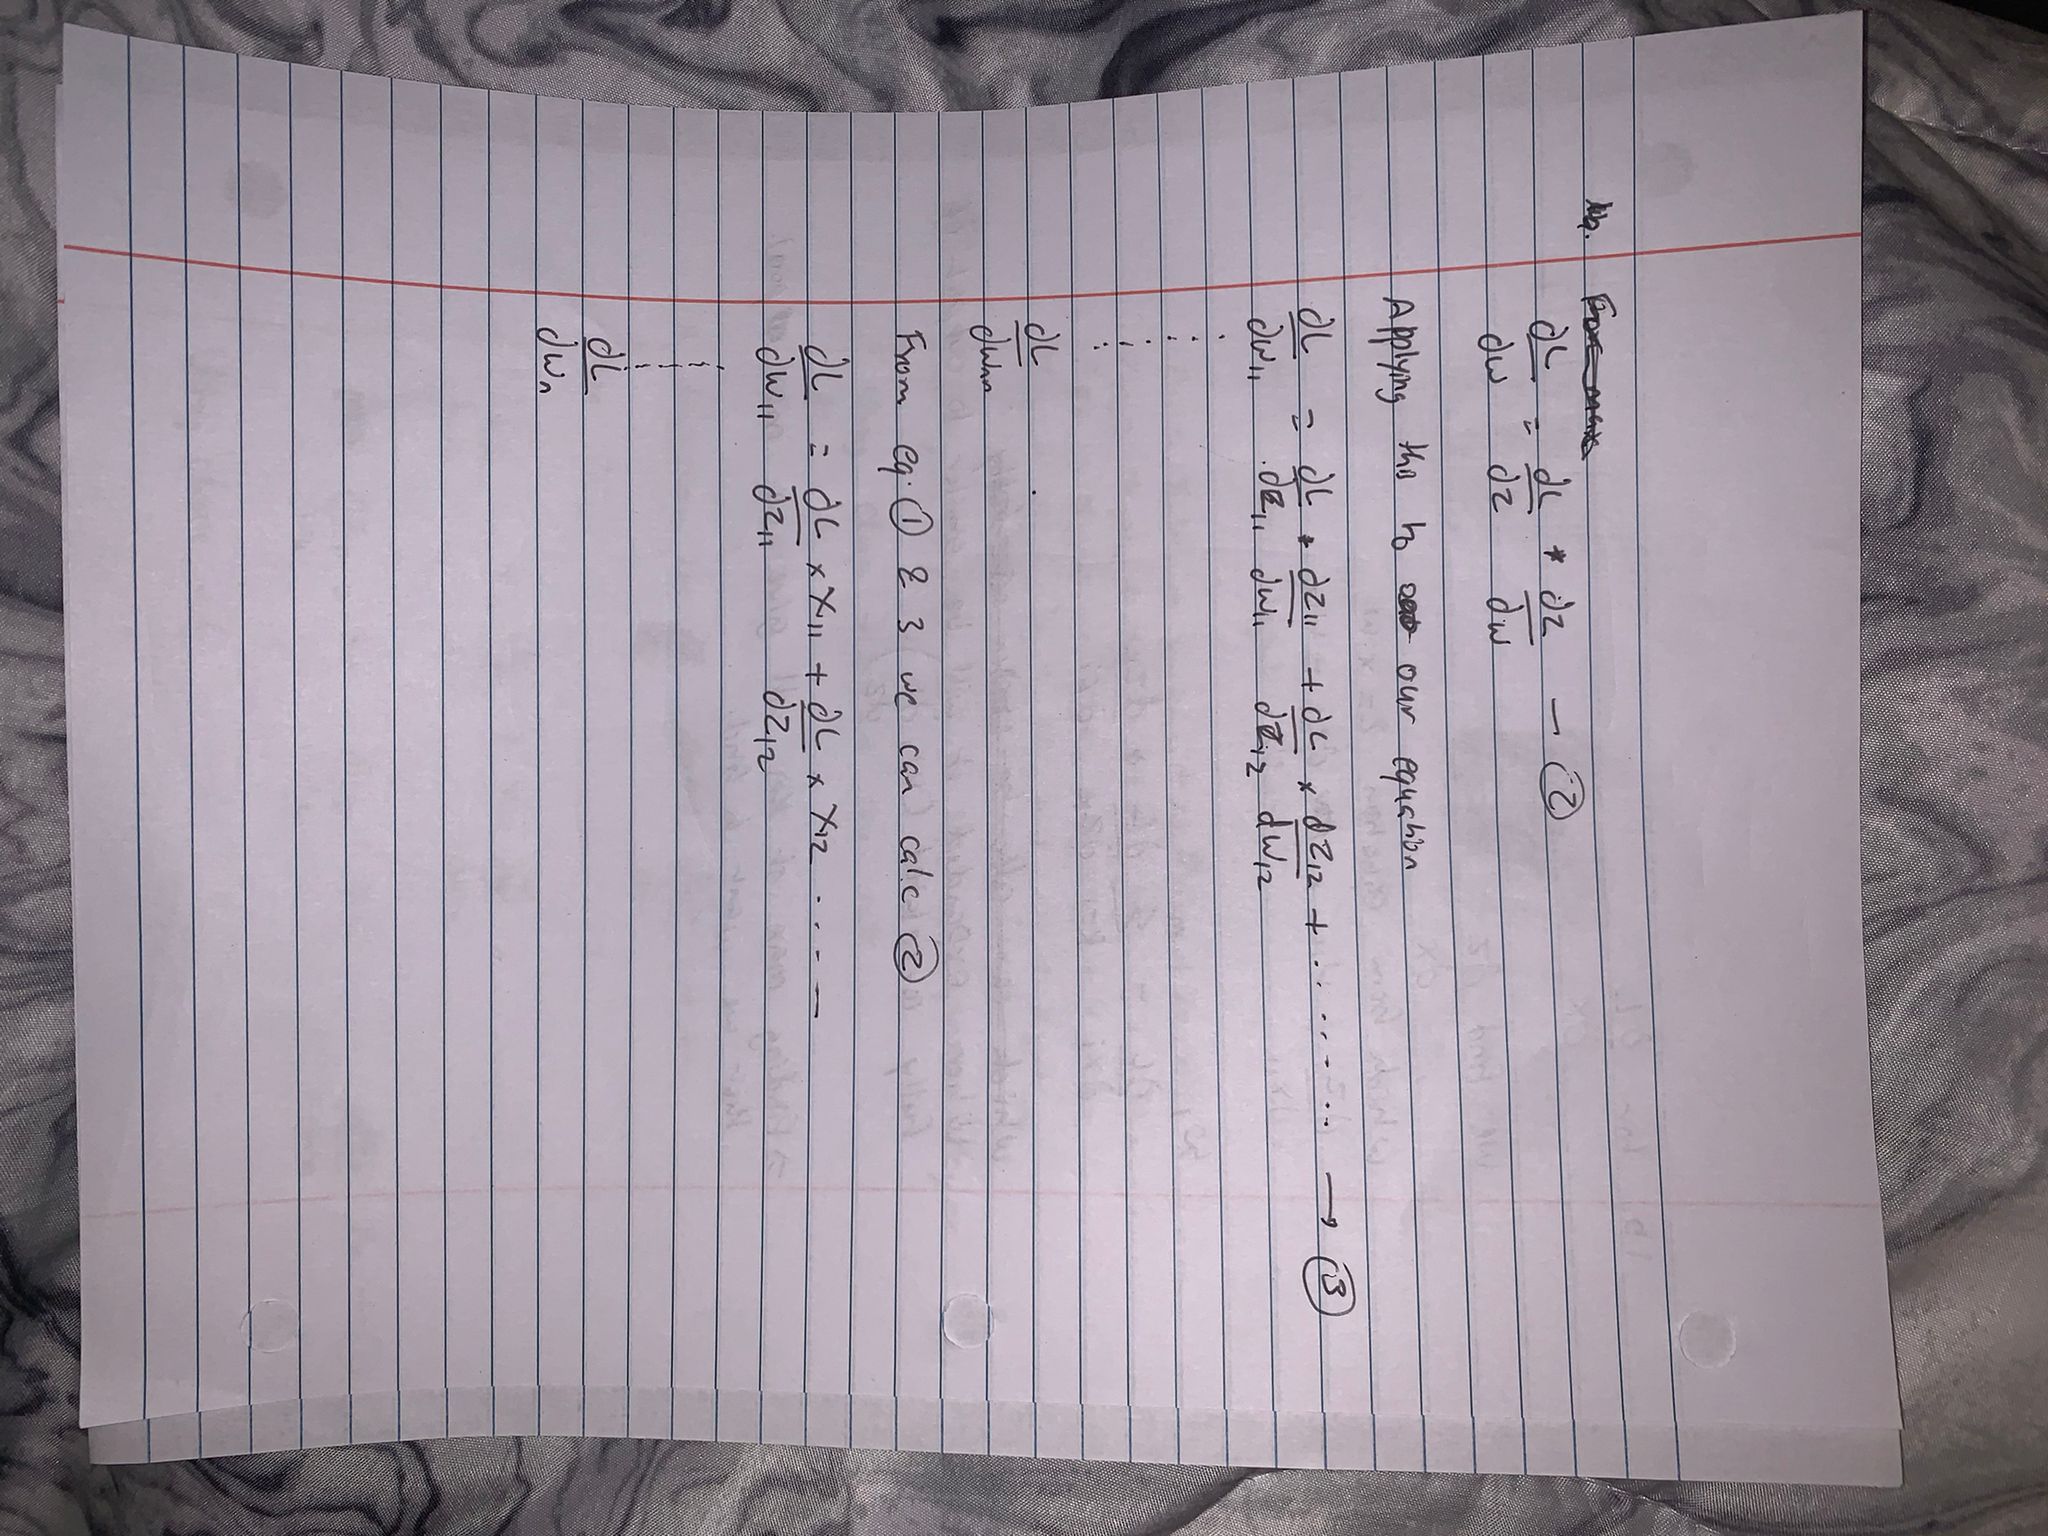

1A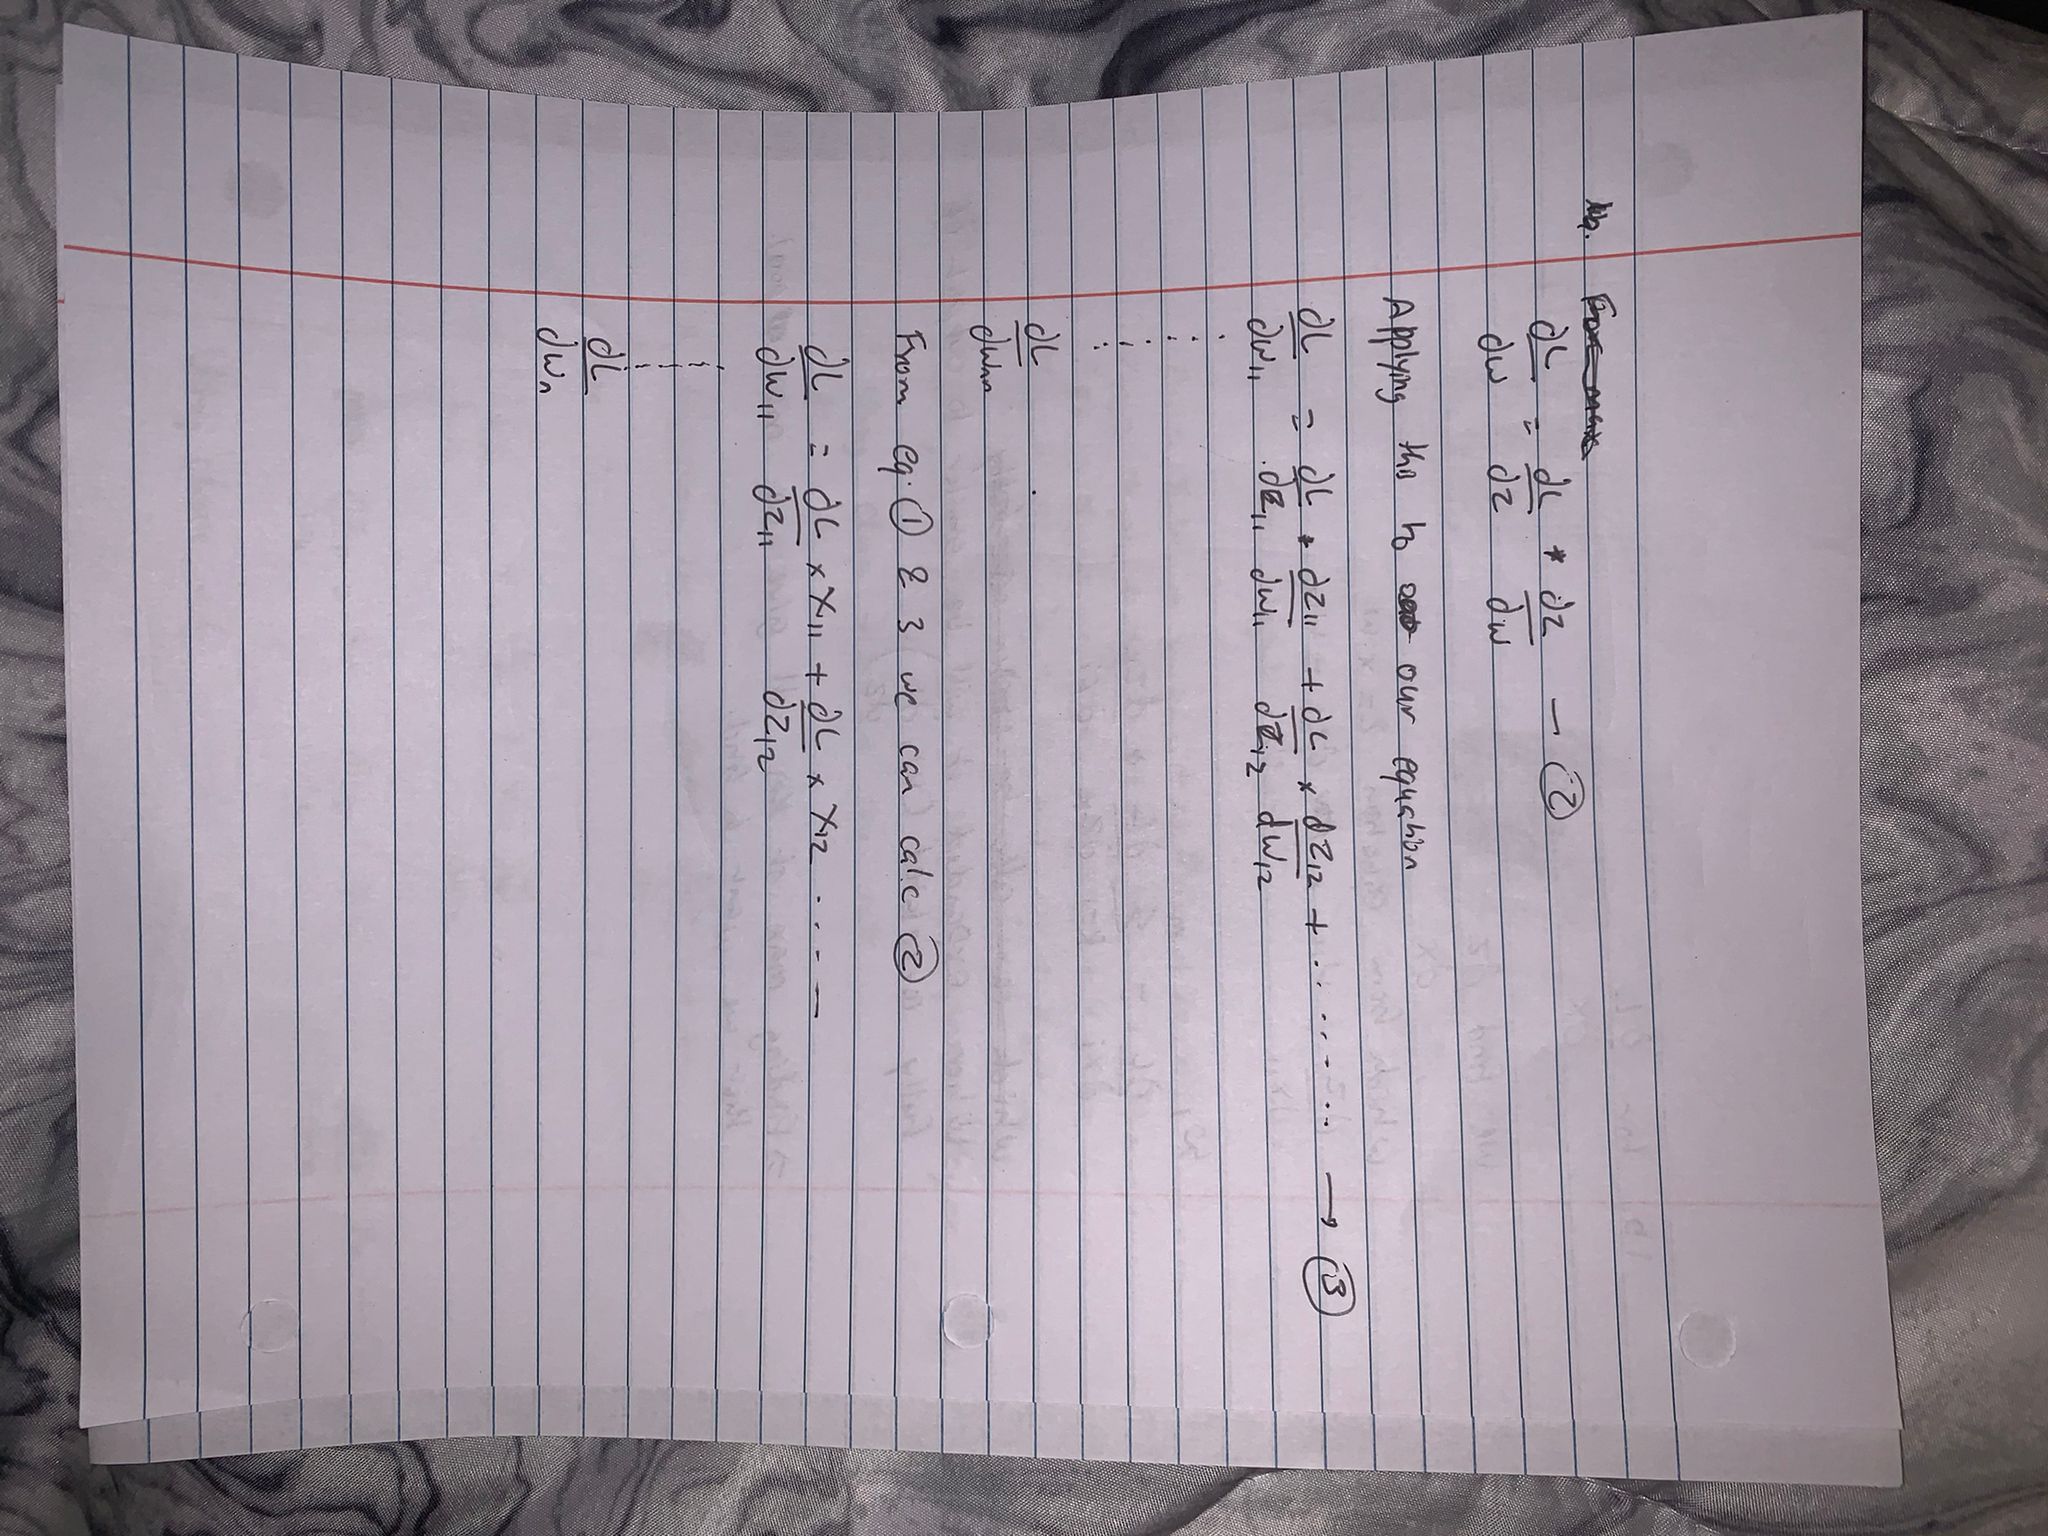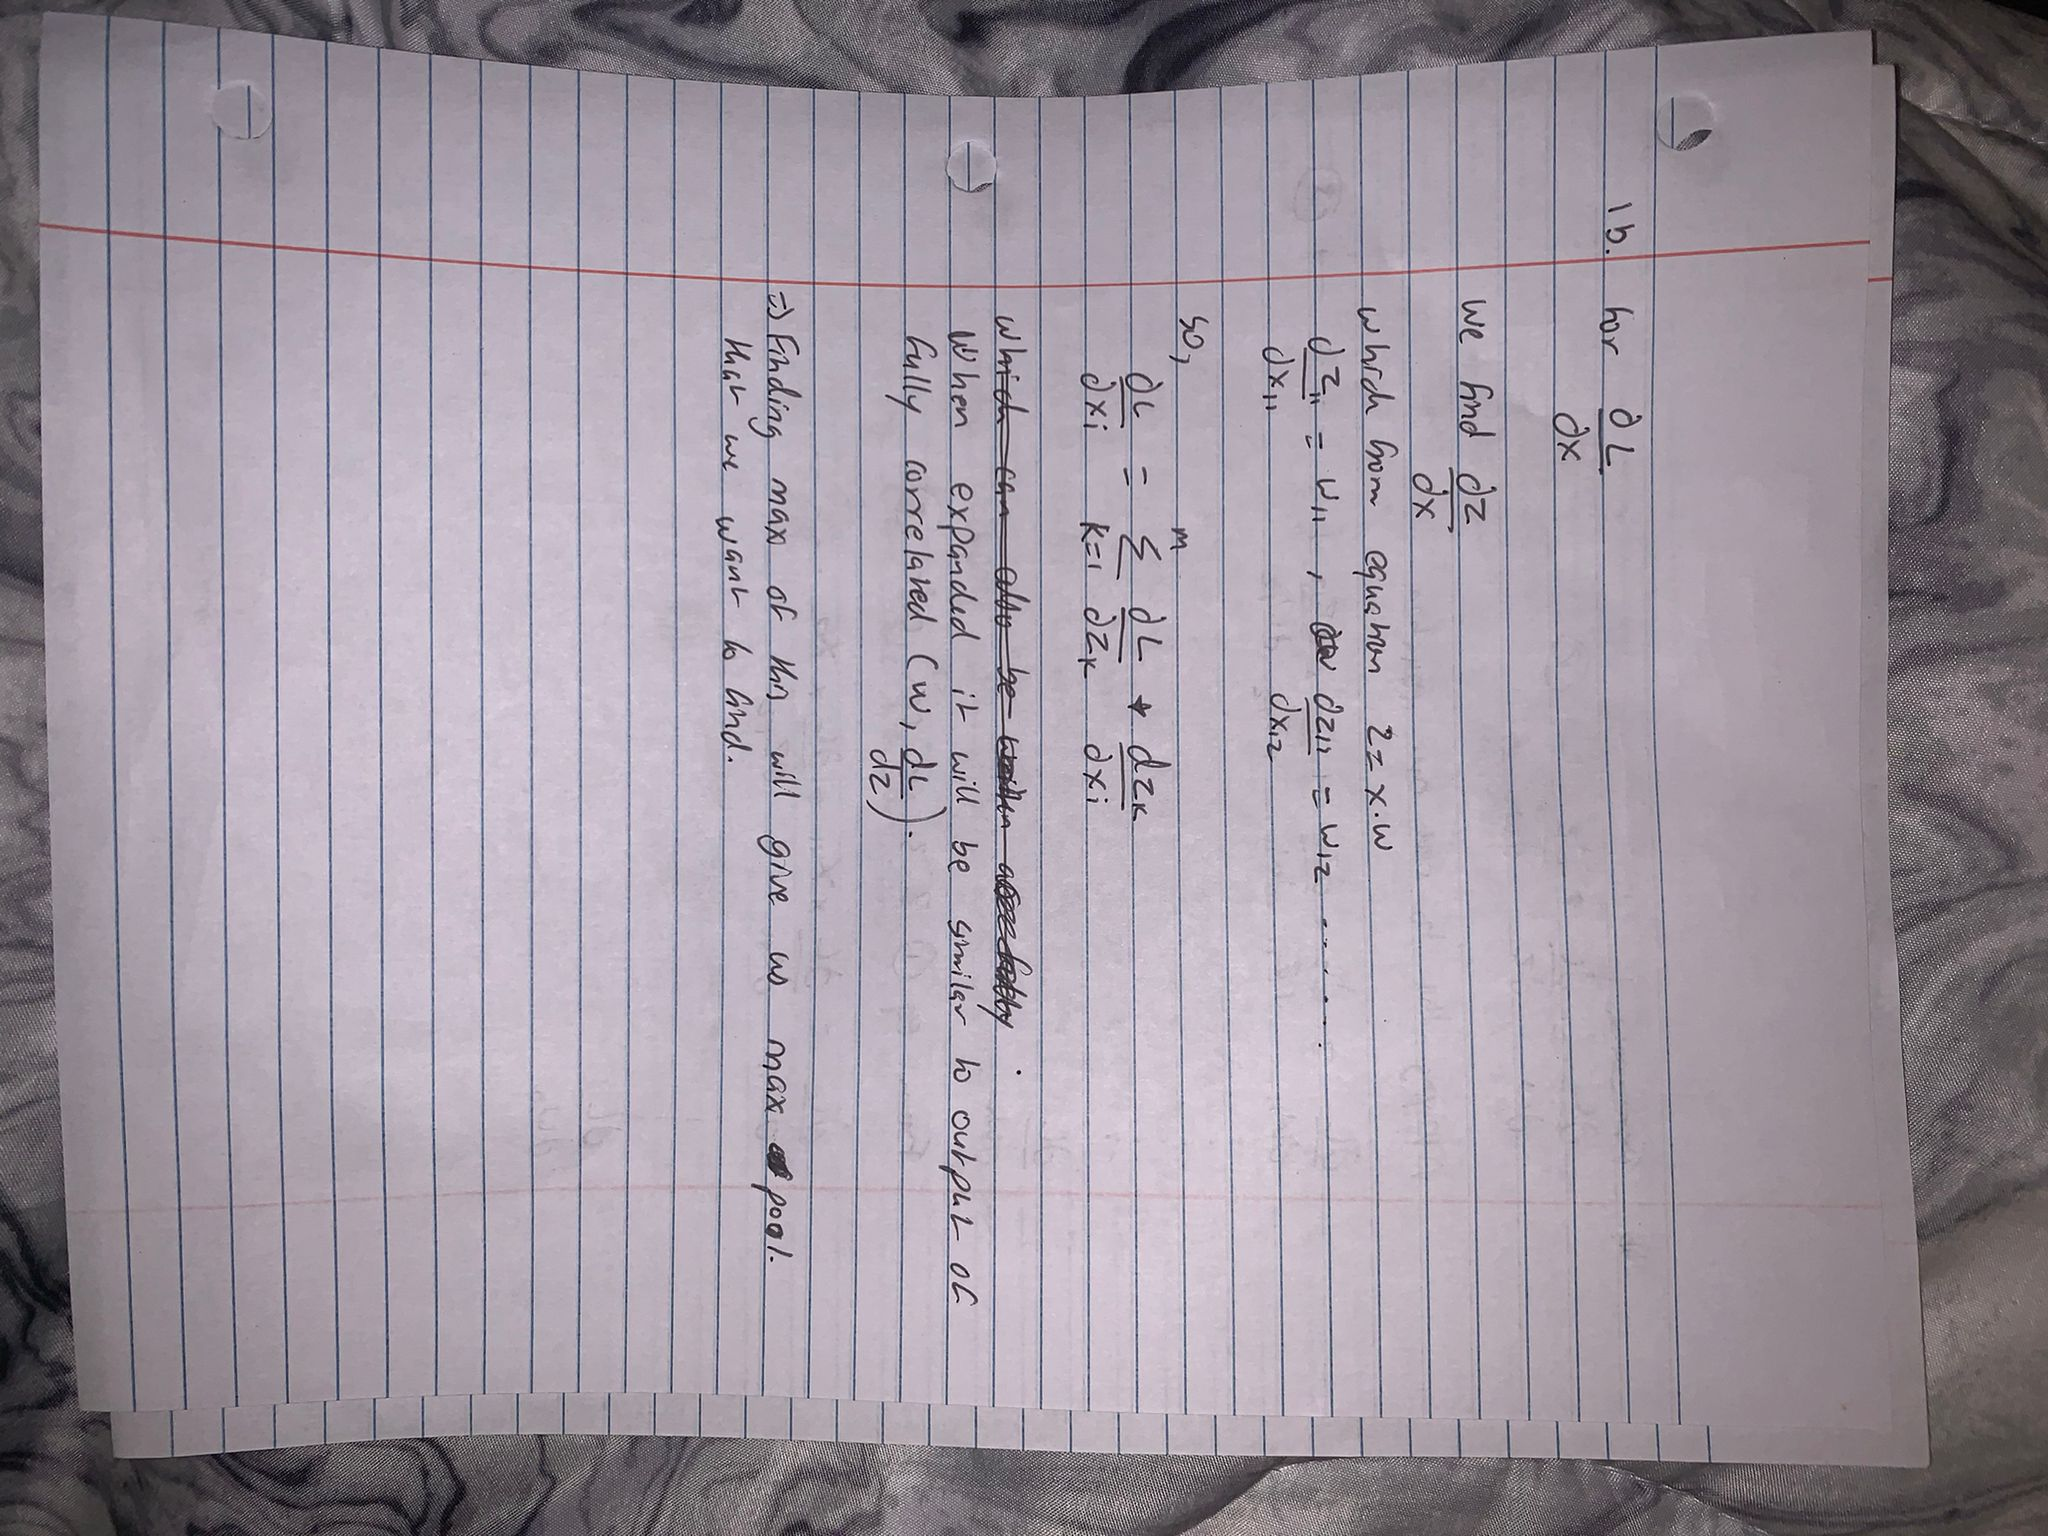

1B

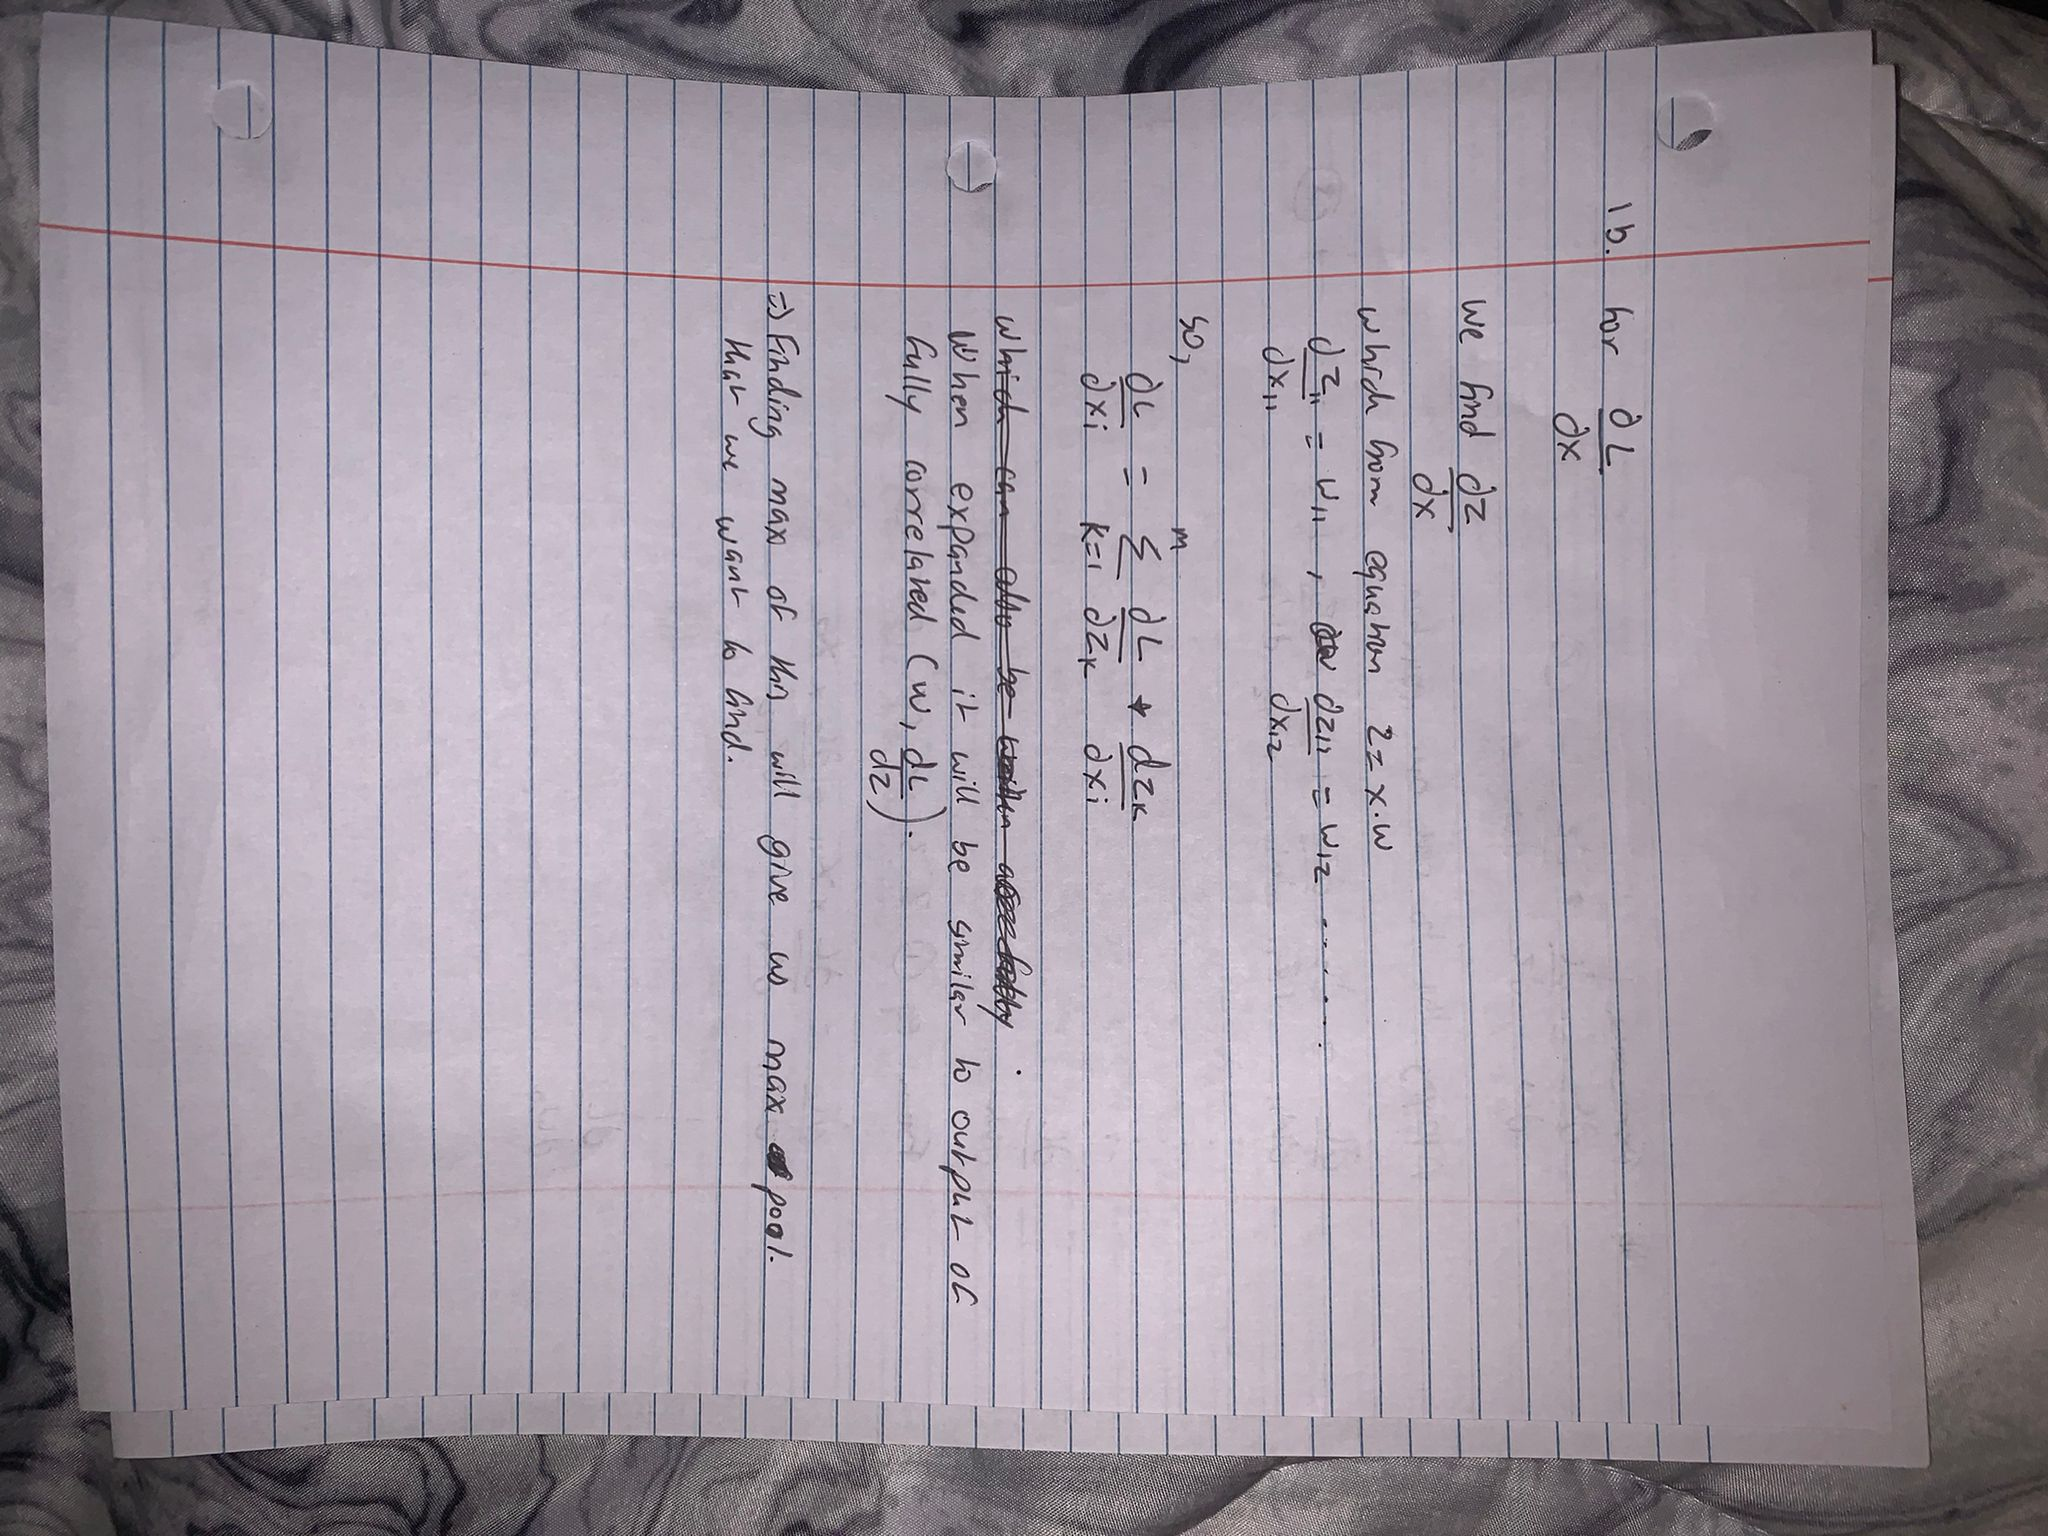

1C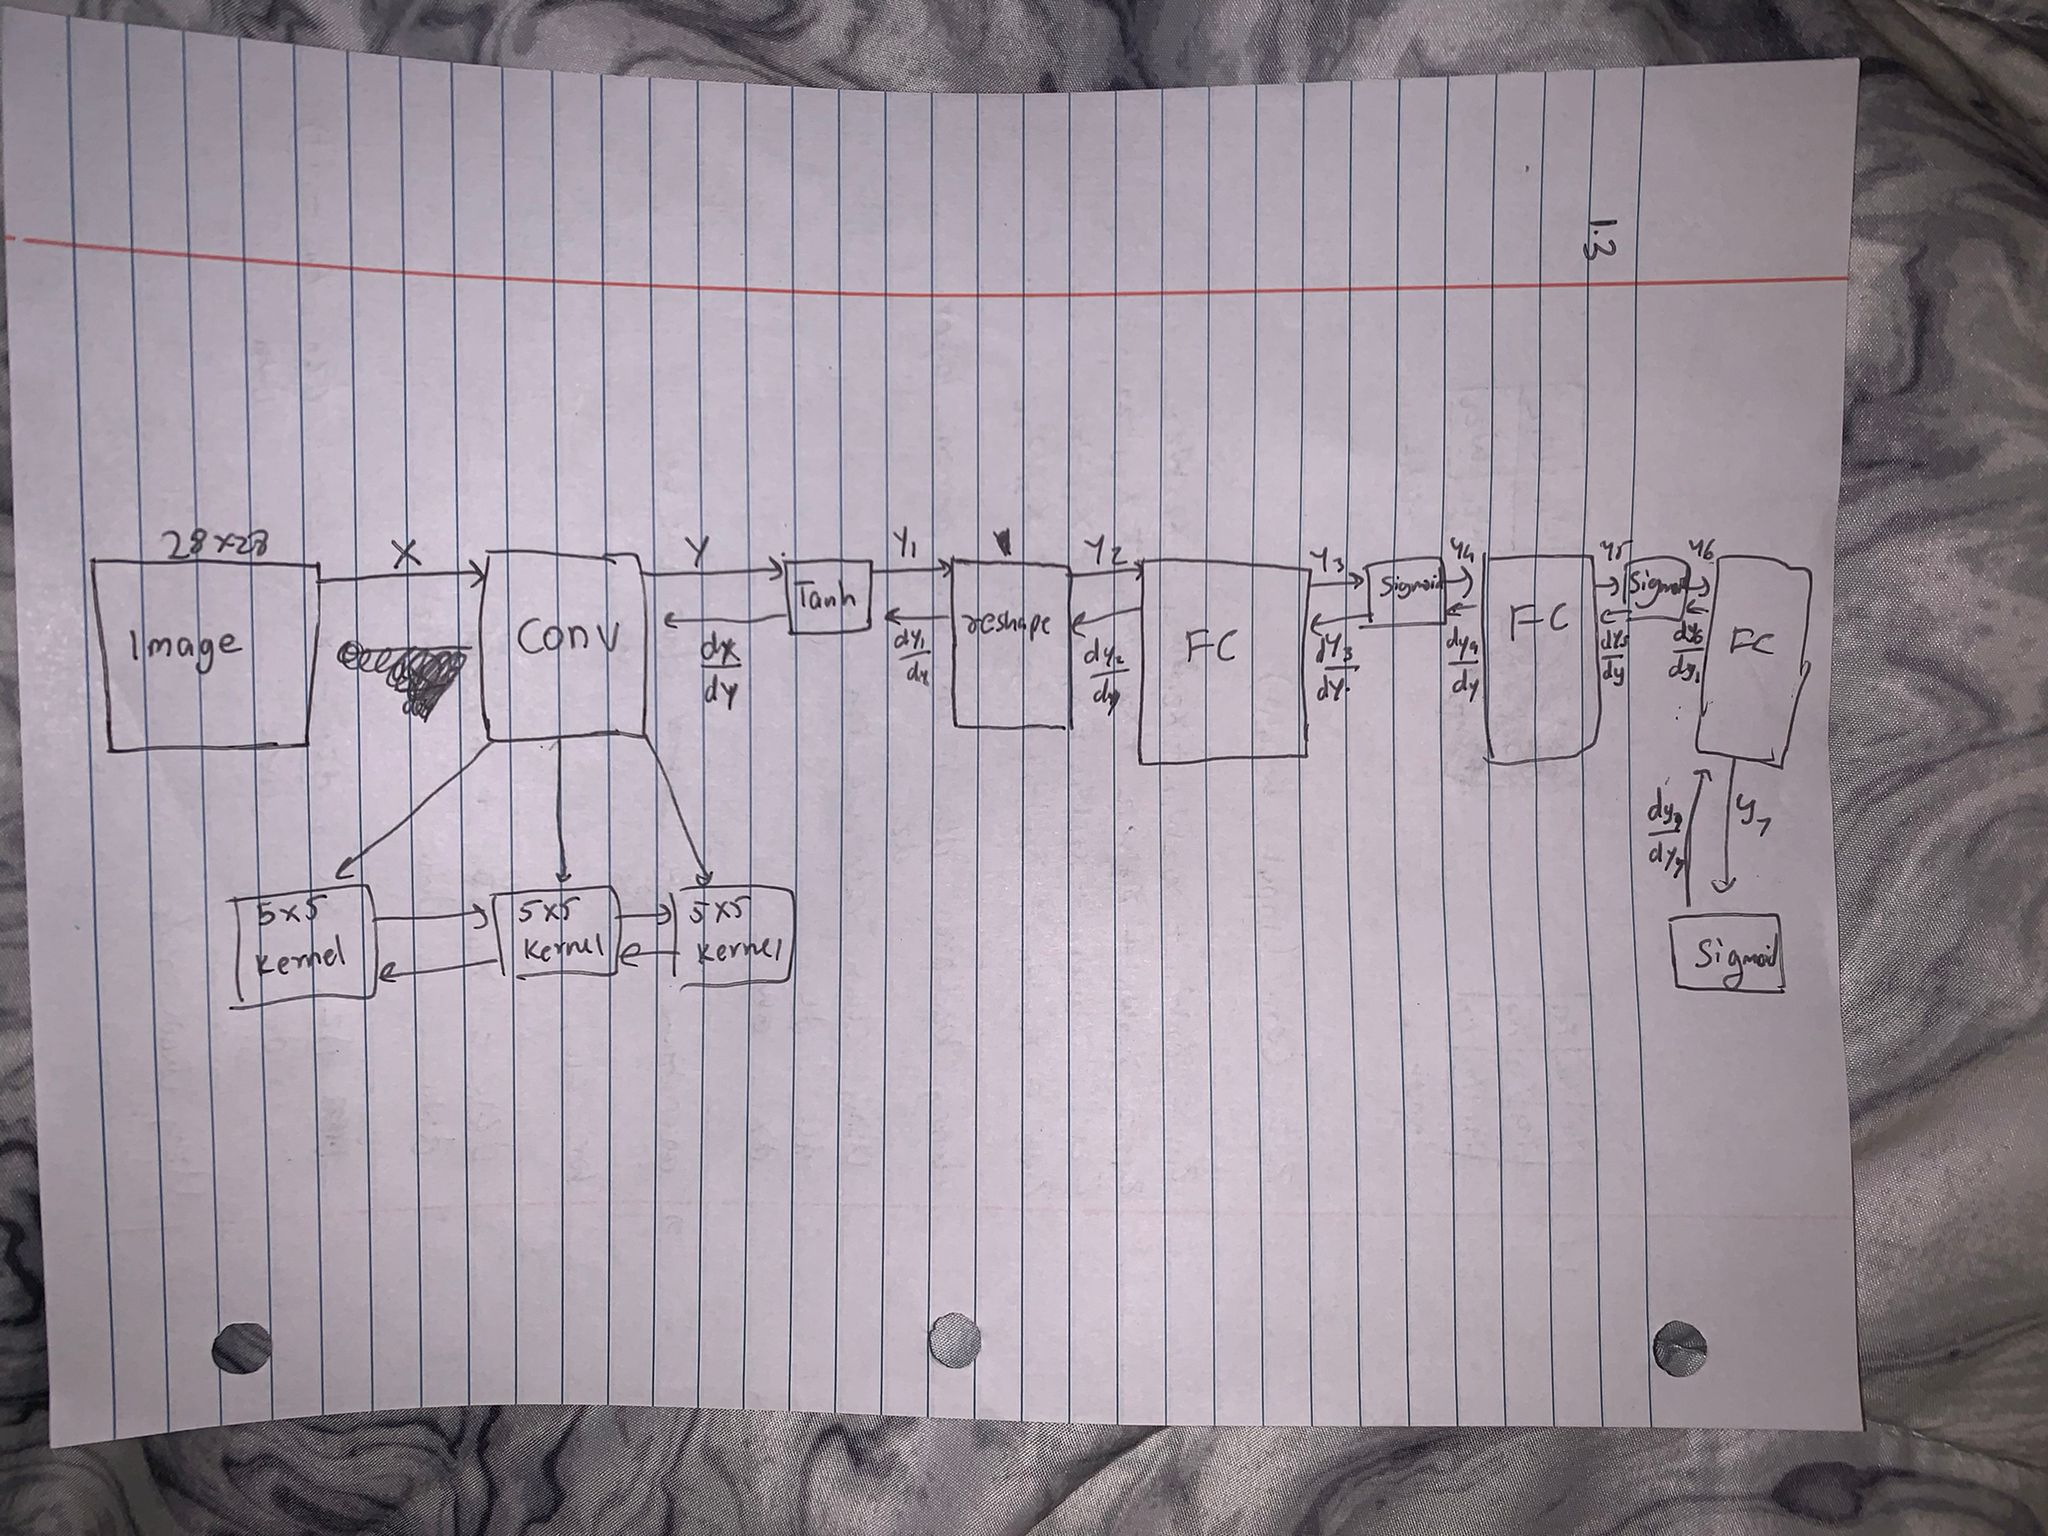

1D


In [ ]:
#creating a class layer for defining the methods used 
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
#for forward pass
    def forward(self, input):
        pass
#for backward pass
    def backward(self, output_derivative, learning_rate):
        pass

In [ ]:
import numpy as np
#creating a fullyconnected class for implementation of fully connected layer and it will inherit the layer class
class FullyConnected(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size) #randomly selecting bias and weights that we have to update after each iteration
        self.bias = np.random.randn(output_size, 1)
#Here it will take input the values from layer before it and produce output which is equals to output=input * weight + bias
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
#for backward pass we will recievce input from layer after it 
    def backward(self, output_derivative, learning_rate):
        weights_derivative = np.dot(output_derivative, self.input.T) # we will take the derivative of weights and input with respect to output and apple formula for backpropagation which is dW = d(output) * input(transpose)
        input_derivative = np.dot(self.weights.T, output_derivative) #take the derivative of imput with respect to output which is given by dX = weights(transpose) * dY
        self.weights -= learning_rate * weights_derivative           #updating the weights and bias for next iteration using learning rate
        self.bias -= learning_rate * output_derivative
        return input_derivative 

In [ ]:
#activation class will be used for creaing activation layer and it also inherits layer class                                  
class Activation(Layer):                             
    def __init__(self, activation, activation_derivative):
        self.activation = activation
        self.activation_derivative = activation_derivative
#for the forward pass it wil take input from fc layer and conv layer and produce output from the functions specified
    def forward(self, input):
        self.input = input
        return self.activation(self.input)
#for backward pass the output will be the dY where Y is output * d(activation fucntion it self)
    def backward(self, output_derivative, learning_rate):
        return np.multiply(output_derivative, self.activation_derivative(self.input))
#Tanh activation class will inherit Activation class
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)
#for backward pass it will use the derivative of the fucntion 
        def tanh_derivative(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_derivative)  #it will inheret the activation class's constructor
#as used in assignment 2 the sigmoid class will produce output using the this formula
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
#for backward pass it will use the derivative of the fucntion 
        def sigmoid_derivative(x):
            s = sigmoid(x)
            return s * (1 - s)
#it will inheret the activation class's constructor
        super().__init__(sigmoid, sigmoid_derivative)

In [ ]:
from scipy import signal
#the main layer of CNN is the conv layer and also the first layer in out architecture it takes as input the image(array)
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1) #usign the formula size of input image - the size of kernel + 1 will give us the output shape for this layer
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)#here we take size of kernels as 5 and no of kernels as 3 
        self.kernels = np.random.randn(*self.kernels_shape) #assigning random values to kernel
        self.biases = np.random.randn(*self.output_shape) #assigning random values to bias
#forward pass will take input and kernel and apply cross correlation which is output = input (corr) kernel + bias
    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid") # using the valid correlation which is the kernel does not cross the margin and the output is smaller than input
        return self.output
#backward pass will take input from class after it and return the derivative of input
    def backward(self, output_derivative, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape) #initialising
        input_derivative = np.zeros(self.input_shape) 

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_derivative[i], "valid")  # here the kernel gradient will be input (corr) dY where y=output 
                input_derivative[j] += signal.convolve2d(output_derivative[i], self.kernels[i, j], "full") # here to calculate dX where x=input we have formula as dY corr(full) with kernels, here full means that the kernel will go outisde the margin and take single values
#upadting parameter for next epoc
        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_derivative
        return input_derivative

In [ ]:
import numpy as np
#defining mean squared error to calculate error loss 
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))
#defining the derivative of mean squared error for the back propagation
def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)


In [ ]:
from keras.utils import np_utils
#crearting a reshape layer as it will be helped to reshape the input before any fc layer as after applying conv the output will not be of same shape, similarly for back prog as well 
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_derivative, learning_rate):
        return np.reshape(output_derivative, self.input_shape)

In [58]:
#predict fucntion is used to predict the labels using out network 
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output
#train fucntion takes in all parameters and trains our network using the parameter to predict the labels
def train(network, loss, loss_derivative, x_train, y_train, epochs = 1000, learning_rate = 0.01):
    for e in range(epochs):
        err = 0
        for x, y in zip(x_train, y_train):
            # forward pass it will take network and data as input and produce the output 
            output = predict(network, x)

            # error here we used mse so it will cal error based on our prediction
            err += loss(y, output)

            # backward pass will apply backward prog on network to reduce the error
            gradient = loss_derivative(y, output)
            for layer in reversed(network):
                gradient = layer.backward(gradient, learning_rate)

        err = err / len(y_train)
        print(f"{e + 1}/{epochs}, error={err}")


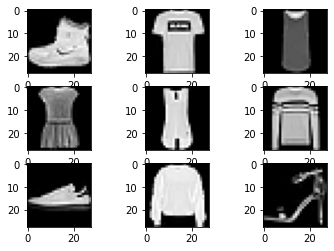

In [59]:
from keras.datasets import  fashion_mnist
from matplotlib import pyplot
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() #importing dataset
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show() #displaying data
x_train=x_train.reshape(len(x), 1, 28, 28) #reshaping the data  
x_test=x_test.reshape(len(x), 1, 28, 28) #reshaping the data 
x_train=x_train.astype("float32") / 255 #normalizing the data
x_test=x_test.astype("float32") / 255
y_train = np_utils.to_categorical(y_train)  # catagorizing the labels from 1-10
y_train = y_train.reshape(len(y_train), 10, 1) 
y_test = np_utils.to_categorical(y_test)
y_test = y_test.reshape(len(y_test), 10, 1)

In [60]:
#network will implement all the layers which are conv, activation, reshape, fc, activation, fc , activation, fc, activation
network = [Convolutional((1, 28, 28), 5, 3),Tanh(),Reshape((3, 24, 24), (3 * 24 * 24, 1)),FullyConnected(3 * 24 * 24, 100),Sigmoid(),FullyConnected(100, 50),Sigmoid(),FullyConnected(50, 10),Sigmoid()]
train(network,mse,mse_derivative,x_train,y_train,epochs=4,learning_rate=0.1)
count=0
ot=[]
#predicting on our test data and calc the accuracy
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    ot.append(output)
    if np.argmax(output) == np.argmax(y):
      count+=1
accuracy=count/len(x_test)
accuracy

1/4, error=0.05388525105093481
2/4, error=0.03427214188678844
3/4, error=0.029763121773082907
4/4, error=0.027626502707483288


0.7999